In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import h5py
from pathlib import Path    
from collections.abc import Iterable

In [2]:
datapath = Path.cwd() / "results/short_times"

In [3]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2)
    else:
        return np.std(A[:,:,0:n_samples],2)

In [4]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

In [5]:
h=[0,0.5,1,1.5,2,2.5,3,5,7,9,11]
jobids = []
params = []
data = []
N = 17
folders = [datapath/"h=0",datapath/"h=0.5",datapath/"h=1",datapath/"h=1.5",
datapath/"h=2",datapath/"h=2.5",datapath/"h=3",datapath/"h=5",datapath/"h=7",datapath/"h=9",datapath/"h=11"]
files = ["5520873_N17_FD.jld2","5568753-5568754_N17.jld2","5568755-5568756_N17.jld2","5568757-5568758_N17.jld2",
"5568759-5568760_N17.jld2","5568761-5568762_N17.jld2","5568763-5568764_N17.jld2","5568765-556766_N17.jld2",
"5568767-5568768_N17.jld2","5601049-5601050_N17.jld2","5601051_5601053_N17.jld2"]
for (i,file) in enumerate(files):
    with h5py.File(folders[i]/file,"r") as f:
        if i == 0:
            jobids.append(f["jobid"][()].decode("UTF-8"))
            data.append(2-2*rearrange_data(f["data"][()]))
            params.append(f["params"][()])
        else:
            jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
            data.append(2-2*np.array([rearrange_data(f[f["data"][l]]) for l in range(len(f["data"]))]))
            params.append(list(f[f["params"][l]][()] for l in range(len(f["params"]))))
for  i in range(1,len(files)):
        data[i] = np.concatenate(data[i],axis=2)
T = np.arange(0,2.01,0.01)
xcenter = N//2

In [6]:
jobids_NN = []
params_NN = []
data_NN = []
N = 17
folders = [datapath/"h=0",datapath/"h=0.5",datapath/"h=1",datapath/"h=1.5",
datapath/"h=2",datapath/"h=2.5",datapath/"h=3",datapath/"h=5",datapath/"h=7",datapath/"h=9",datapath/"h=11"]
files_NN = ["5520874_N17_FD.jld2","5568773-5568774_N17_NN.jld2","5568775-5568776_N17_NN.jld2","5568777-5568778_N17_NN.jld2","5568779-5568780_N17_NN.jld2",
"5568784-5568785_N17_NN.jld2","5568788-5568789_N17_NN.jld2","5568790_5568797_N17_NN.jld2","5568798-5568799_N17_NN.jld2","5603140-5603141_N17_NN.jld2",
"5603142-5603143_N17_NN.jld2"]
for (i,file) in enumerate(files_NN):
    with h5py.File(folders[i]/file,"r") as f:
        if i == 0:
            jobids_NN.append(f["jobid"][()].decode("UTF-8"))
            data_NN.append(2-2*rearrange_data(f["data"][()]))
            params_NN.append(f["params"][()])
        else:
            jobids_NN.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
            data_NN.append(2-2*np.array([rearrange_data(f[f["data"][l]]) for l in range(len(f["data"]))]))
            params_NN.append(list(f[f["params"][l]][()] for l in range(len(f["params"]))))
for  i in range(1,len(files)):
        data_NN[i] = np.concatenate(data_NN[i],axis=2)

In [7]:
res = list(map(lambda arr: disorder_mean(arr),data))
res_err = list(map(lambda arr: disorder_std(arr),data))
res_NN = list(map(lambda arr: disorder_mean(arr),data_NN))
res_err_NN = list(map(lambda arr: disorder_std(arr),data_NN))

In [8]:
xvals = np.array([abs(pos-xcenter) for pos in range(1,N+1)])

In [9]:
def model(x,a,b,c):
    return a*x**b+c

In [10]:
np.max(np.abs(res[0]-res_NN[0]),axis=0)

array([0.00447233, 0.00596915, 0.00767412, 0.00596503, 0.00471262,
       0.00587619, 0.00683455, 0.01174842, 0.00710823, 0.011285  ,
       0.01123612, 0.00582353, 0.00781476, 0.01050379, 0.01170309,
       0.00403236, 0.00114585])

## h=0

In [11]:
idh = 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


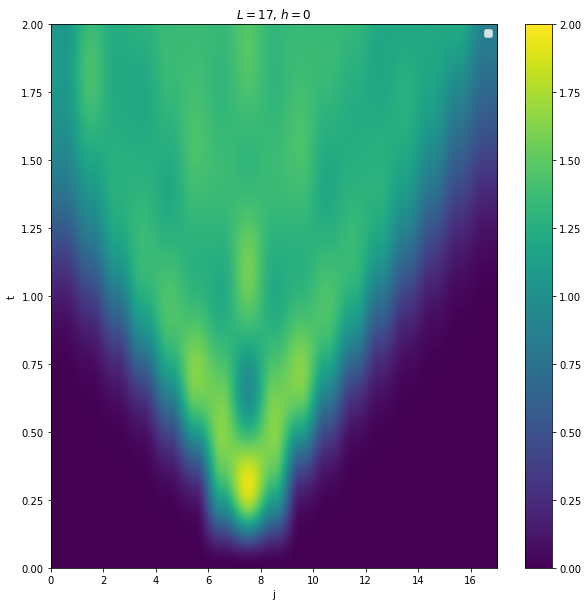

In [12]:
#thresholds = [0.25,0.5,0.75]#,1.25,1.5,1.75,2]
#fit_params = []
#fit_errs = []
#tvals = []
#for (i,th) in enumerate(thresholds):
#    tvals.append(T_transgression(T,res[idh],th))
#    popt, pcov = curve_fit(model,xvals,tvals[i])
#    fit_params.append(popt)
#    fit_errs.append(np.sqrt(np.diag(pcov)))
idh=0
plt.figure(figsize=(10,10))
linestyles = ["-","--","-."]
plt.imshow(res[idh],cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
#for (i,th) in enumerate(thresholds):
#    plt.plot(np.arange(0,N,1)+0.5,model(xvals,*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--")
#    plt.scatter(np.arange(0,N,1)+0.5,tvals[i], marker= "d")
plt.clim(0,2)
plt.colorbar()
plt.xlabel("j")
plt.ylabel("t")
plt.legend()
plt.title(r"$L=17$, $h=0$")
plt.show()

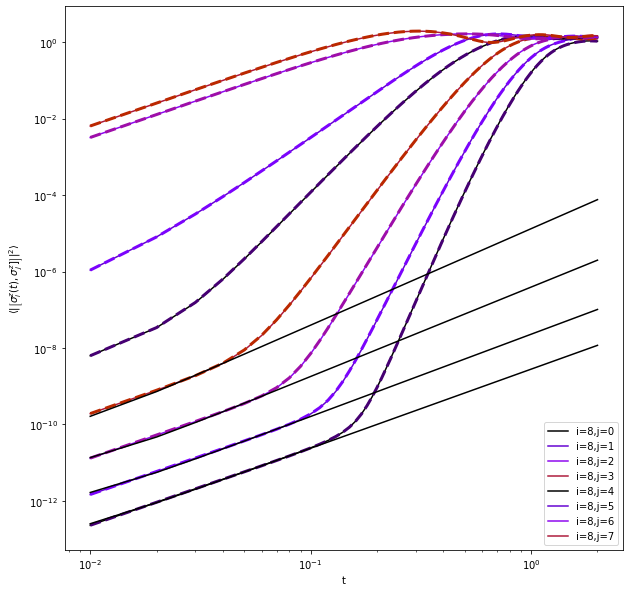

In [13]:
idh = 0
popt = []
perr = []
tmax = [10,9,7,5]
for j in range(0,4):
    poptj, pcovj = curve_fit(model,T[0:tmax[j]],res[idh][0:tmax[j],j])
    popt.append(poptj)
    perr.append(np.sqrt(np.diag(pcovj)))


NUM_COLORS = N//2
cm = plt.get_cmap('gnuplot')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS+5)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
for j in range(0,N//2):
    ax.loglog(T[1:],res[idh][1:,j],label="i={},j={}".format(N//2,j))
    ax.loglog(T[1:],res_NN[idh][1:,j],linestyle="--",linewidth=3)
    if j < 4:
        ax.loglog(T[1:],model(T[1:],*(popt[j])),color='black')
ax.legend(loc="lower right")
ax.set_xlabel("t")
ax.set_ylabel(r"$\langle\left|\left[\sigma_i^z(t),\sigma_j^z]\right]\right|^2\rangle$")
#ax.set_ylim(1e-12,5)
plt.show()

In [14]:
popt

[array([2.79612828e-09, 2.06870516e+00, 4.97641650e-14]),
 array([2.29128283e-08, 2.15215547e+00, 5.27465159e-13]),
 array([3.91666166e-07, 2.33922157e+00, 5.39372071e-12]),
 array([1.31843800e-05, 2.52342649e+00, 4.50166630e-11])]

## other h

h=11


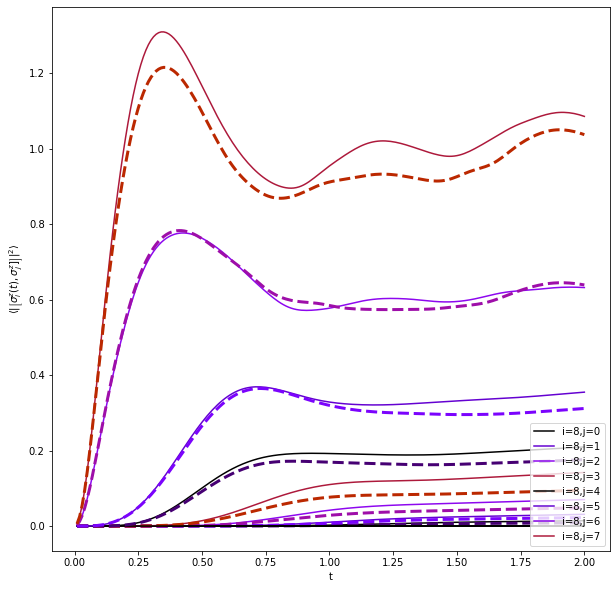

In [17]:
idh = 10
print("h={}".format(h[idh]))
popt = []
perr = []
tmax = [10,9,7,5]
for j in range(0,4):
    poptj, pcovj = curve_fit(model,T[0:tmax[j]],res[idh][0:tmax[j],j])
    popt.append(poptj)
    perr.append(np.sqrt(np.diag(pcovj)))


NUM_COLORS = N//2
cm = plt.get_cmap('gnuplot')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS+5)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
for j in range(0,N//2):
    ax.plot(T[1:],res[idh][1:,j],label="i={},j={}".format(N//2,j))
    ax.plot(T[1:],res_NN[idh][1:,j],linestyle="--",linewidth=3)
    if j < 4:
        ax.plot(T[1:],model(T[1:],*(popt[j])),color='black')
ax.legend(loc="lower right")
ax.set_xlabel("t")
ax.set_ylabel(r"$\langle\left|\left[\sigma_i^z(t),\sigma_j^z]\right]\right|^2\rangle$")
#ax.set_ylim(1e-12,5)
plt.show()

In [17]:
popt

[array([ 1.48786329e-09,  1.87000909e+00, -4.09641887e-14]),
 array([1.35204526e-08, 1.98930122e+00, 1.44701598e-13]),
 array([2.55934918e-07, 2.21635071e+00, 3.97240463e-12]),
 array([1.06379648e-05, 2.46925245e+00, 4.12315895e-11])]

## Compare with $\alpha=2$

In [19]:
jobids_a2 = []
params_a2 = []
data_a2 = []
N = 17
folders_a2 = [datapath/"h=0"]
files_a2 = ["5644352_N17_FD.jld2","5644353_N17_FD.jld2"]
for (i,file) in enumerate(files_a2):
    with h5py.File(folders_a2[0]/file,"r") as f:
        jobids_a2.append(f["jobid"][()].decode("UTF-8"))
        data_a2.append(2-2*rearrange_data(f["data"][()]))
        params_a2.append(f["params"][()])


h=11


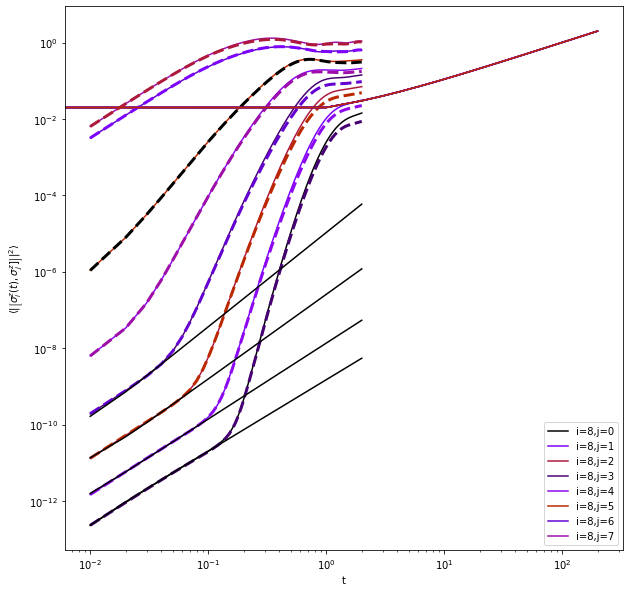

In [20]:
idh = 10
print("h={}".format(h[idh]))
popt = []
perr = []
tmax = [10,9,7,5]
for j in range(0,4):
    poptj, pcovj = curve_fit(model,T[0:tmax[j]],res[idh][0:tmax[j],j])
    popt.append(poptj)
    perr.append(np.sqrt(np.diag(pcovj)))


NUM_COLORS = N//2
cm = plt.get_cmap('gnuplot')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS+5)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
for j in range(0,N//2):
    ax.plot(T[1:],res[idh][1:,j],label="i={},j={}".format(N//2,j))
    ax.plot(T[1:],res_NN[idh][1:,j],linestyle="--",linewidth=3)
    if j < 4:
        ax.loglog(T[1:],model(T[1:],*(popt[j])),color='black')
    ax.loglog(T[1:])
ax.legend(loc="lower right")
ax.set_xlabel("t")
ax.set_ylabel(r"$\langle\left|\left[\sigma_i^z(t),\sigma_j^z]\right]\right|^2\rangle$")
#ax.set_ylim(1e-12,5)
plt.show()

In [21]:
res_a2 = list(map(lambda arr: disorder_mean(arr),data_a2))
res_err_a2 = list(map(lambda arr: disorder_std(arr),data_a2))

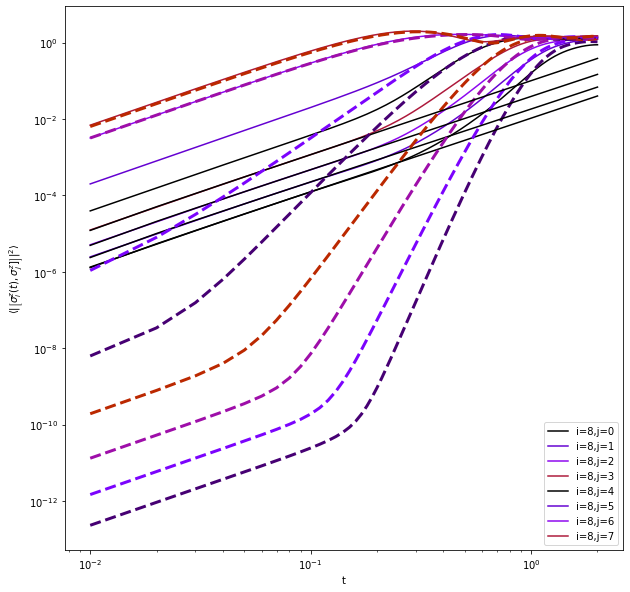

In [22]:
popt = []
perr = []
tmax = [10,10,10,10]
for j in range(0,4):
    poptj, pcovj = curve_fit(model,T[0:tmax[j]],res_a2[0][0:tmax[j],j])
    popt.append(poptj)
    perr.append(np.sqrt(np.diag(pcovj)))


NUM_COLORS = N//2
cm = plt.get_cmap('gnuplot')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS+5)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
for j in range(0,N//2):
    ax.loglog(T[1:],res_a2[0][1:,j],label="i={},j={}".format(N//2,j))
    ax.loglog(T[1:],res_NN[0][1:,j],linestyle="--",linewidth=3)
    if j < 4:
        ax.loglog(T[1:],model(T[1:],*(popt[j])),color='black')
ax.legend(loc="lower right")
ax.set_xlabel("t")
ax.set_ylabel(r"$\langle\left|\left[\sigma_i^z(t),\sigma_j^z]\right]\right|^2\rangle$")
#ax.set_ylim(1e-12,5)
plt.show()

In [38]:
popt

[array([ 1.05806499e-02,  1.92730179e+00, -1.92213624e-07]),
 array([ 1.83589571e-02,  1.90735920e+00, -4.45119287e-07]),
 array([ 3.92367209e-02,  1.91702236e+00, -8.12112061e-07]),
 array([ 1.01318234e-01,  1.93575784e+00, -1.45823929e-06])]

In [39]:
perr

[array([1.90295713e-04, 7.44357258e-03, 1.11601295e-07]),
 array([4.12010294e-04, 9.29093330e-03, 2.57354013e-07]),
 array([7.59528501e-04, 8.01280939e-03, 4.60139718e-07]),
 array([1.37892233e-03, 5.63198480e-03, 7.87391999e-07])]